1th iteration of API extraction completed.
2th iteration of API extraction completed.
3th iteration of API extraction completed.
4th iteration of API extraction completed.
5th iteration of API extraction completed.


C:\Users\vasub\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


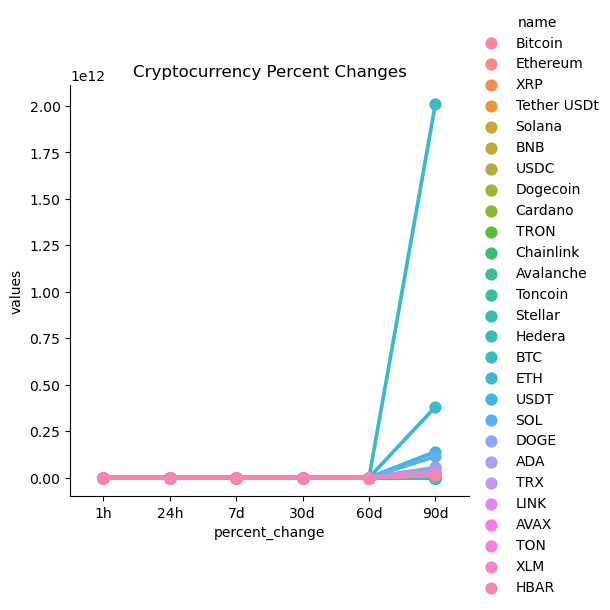

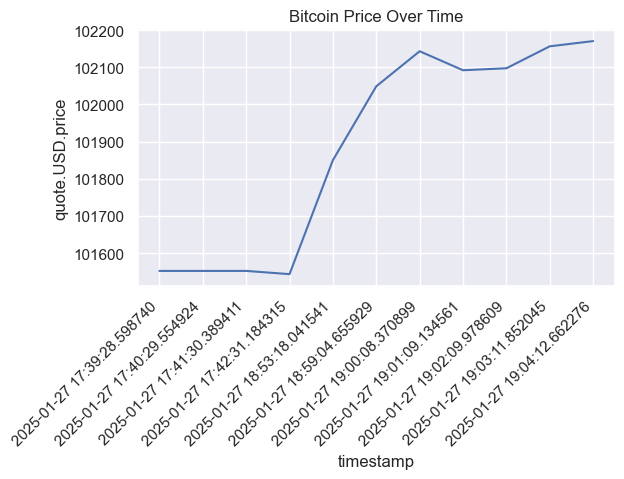

In [2]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from requests import Request, Session
from requests.exceptions import ConnectionError, Timeout, TooManyRedirects
from time import sleep
from datetime import datetime


# Function to automate API data pull
def api_runner(api_key, output_file):
    """
    Automates API data pulling, saves the data into a CSV file.
    """
    url = 'https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest'
    parameters = {
        'start': '1',
        'limit': '15',
        'convert': 'USD'
    }
    headers = {
        'Accepts': 'application/json',
        'X-CMC_PRO_API_KEY': api_key,
    }

    session = Session()
    session.headers.update(headers)

    try:
        response = session.get(url, params=parameters)
        data = json.loads(response.text)

        # Normalize JSON data to a DataFrame
        df = pd.json_normalize(data['data'])
        df['timestamp'] = datetime.now()

        # Save the data to a CSV file
        if not os.path.isfile(output_file):
            df.to_csv(output_file, index=False)
        else:
            df.to_csv(output_file, mode='a', header=False, index=False)

    except (ConnectionError, Timeout, TooManyRedirects) as e:
        print(f"Error while fetching data: {e}")


# Function to process and clean the data
def clean_and_transform_data(input_file):
    """
    Reads the CSV file, processes, and transforms it for EDA and visualization.
    """
    # Load the data
    df = pd.read_csv(input_file)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

    # Group and calculate mean percent changes
    df_grouped = df.groupby('name', sort=False)[
        [
            'quote.USD.percent_change_1h',
            'quote.USD.percent_change_24h',
            'quote.USD.percent_change_7d',
            'quote.USD.percent_change_30d',
            'quote.USD.percent_change_60d',
            'quote.USD.percent_change_90d'
        ]
    ].mean()

    # Transform grouped data to a long format
    df_stacked = df_grouped.stack().to_frame(name="values").reset_index()
    df_stacked.rename(columns={'level_1': 'percent_change'}, inplace=True)

    # Rename percent_change columns for readability
    df_stacked['percent_change'] = df_stacked['percent_change'].replace(
        [
            'quote.USD.percent_change_1h',
            'quote.USD.percent_change_24h',
            'quote.USD.percent_change_7d',
            'quote.USD.percent_change_30d',
            'quote.USD.percent_change_60d',
            'quote.USD.percent_change_90d'
        ],
        ['1h', '24h', '7d', '30d', '60d', '90d']
    )

    return df, df_stacked


# Function to visualize percent changes
def visualize_percent_changes(df_stacked):
    """
    Creates a point plot of percent changes by cryptocurrency.
    """
    sns.catplot(x='percent_change', y='values', hue='name', data=df_stacked, kind='point')
    plt.title('Cryptocurrency Percent Changes')
    plt.show()


# Function to visualize Bitcoin prices
def visualize_bitcoin_prices(df):
    """
    Creates a time-series line plot of Bitcoin prices.
    """
    df_bitcoins = df.query("name == 'Bitcoin'")
    sns.set_theme(style="darkgrid")

    sns.lineplot(x='timestamp', y='quote.USD.price', data=df_bitcoins)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.title('Bitcoin Price Over Time')
    plt.show()


# Main execution block
if __name__ == "__main__":
    API_KEY = '571776fb-8892-42d1-890f-d63e3fe93b16'  # Replace with your API key
    OUTPUT_FILE = os.path.join(os.getcwd(), "API.csv")

    # Automate API pulling
    for i in range(5):  # Adjust the range as needed
        api_runner(API_KEY, OUTPUT_FILE)
        print(f"{i + 1}th iteration of API extraction completed.")
        sleep(60)  # Sleep for 60 seconds between iterations

    # Process and clean the data
    df_final, df_transformed = clean_and_transform_data(OUTPUT_FILE)

    # Visualizations
    visualize_percent_changes(df_transformed)
    visualize_bitcoin_prices(df_final)
